<a href="https://colab.research.google.com/github/willcosta29/Pipeline_telegram_bot/blob/main/Pipeline_telegram_bot.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<img src="https://raw.githubusercontent.com/andre-marcos-perez/ebac-course-utils/main/media/logo/newebac_logo_black_half.png" alt="ebac-logo">

---

# **Módulo** | Pipeline de Dados do Telegram I
Caderno de **Exercícios**<br>
Professor [André Perez](https://www.linkedin.com/in/andremarcosperez/)

---

---

Primeira etapa é a criação do bot atravez do "BotFather"

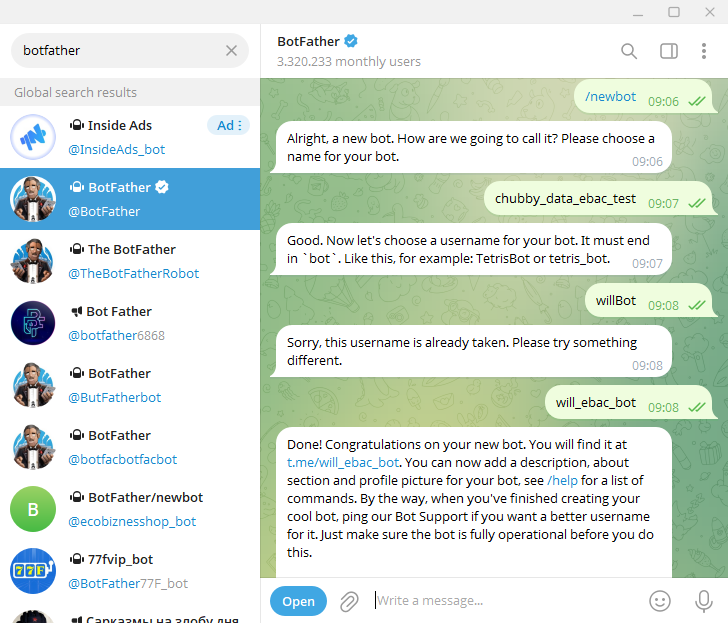

A proxima etapa é colocar o bot no grupo que deseja colher as informações e o adiciona como ADM para se obter as permissões desejadas.

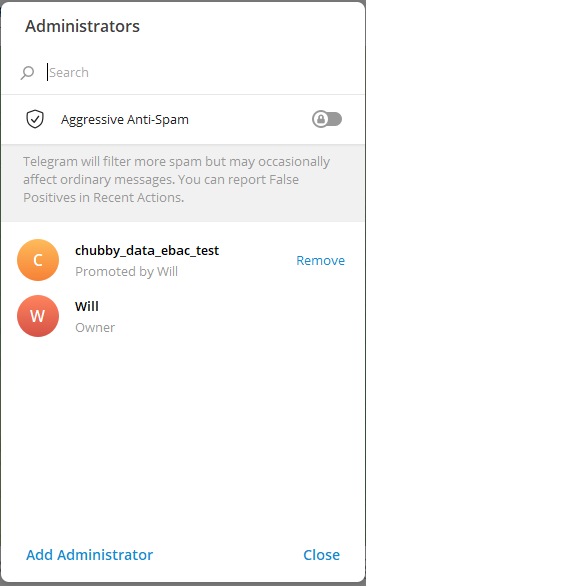

O código abaixo importa a função `getpass` para solicitar de forma segura o token do bot do Telegram.

In [ ]:
from getpass import getpass

token = getpass()

··········


Este trecho de código importa as bibliotecas `json` e `requests` e constrói a URL base para a API do Bot do Telegram usando o token fornecido.

In [ ]:
import json

import requests

base_url = f'https://api.telegram.org/bot{token}'

Este código faz uma chamada à API `getMe` para verificar as informações do bot e imprime a resposta.

In [ ]:
response = requests.get(url=f'{base_url}/getMe')
print(f'{base_url}/getMe')

print(json.dumps(json.loads(response.text), indent=2))

https://api.telegram.org/bot8392968942:AAEx1JbGBP2byiJw2FPcRYL5nwGxV7auJBI/getMe
{
  "ok": true,
  "result": {
    "id": 8392968942,
    "is_bot": true,
    "first_name": "chubby_data_ebac_test",
    "username": "will_ebac_bot",
    "can_join_groups": false,
    "can_read_all_group_messages": false,
    "supports_inline_queries": false,
    "can_connect_to_business": false,
    "has_main_web_app": false
  }
}


Este código faz uma chamada à API `getUpdates` para buscar por novas mensagens e imprime a resposta. Note que pode ocorrer um erro se um webhook estiver ativo.

In [ ]:
response = requests.get(url=f'{base_url}/getUpdates')

print(json.dumps(json.loads(response.text), indent=2))

{
  "ok": false,
  "error_code": 409,
  "description": "Conflict: can't use getUpdates method while webhook is active; use deleteWebhook to delete the webhook first"
}


In [ ]:
with open('telegram.json', mode='w', encoding='utf8') as fp:
  json.dump(json.loads(response.text), fp, indent=2)

Este código salva a resposta da API `getUpdates` em um arquivo JSON chamado `telegram.json`.

In [ ]:
import json

with open('telegram.json', mode='r', encoding='utf8') as fp:
  data = json.load(fp)
  for update in data.get("result", []):
    if "message" in update:
      message = update["message"]
      print(message)

Este código lê o arquivo `telegram.json` e itera sobre a lista de atualizações ('result'), imprimindo as mensagens encontradas.

In [ ]:
print(json.dumps(data, indent=2))

{
  "ok": false,
  "error_code": 409,
  "description": "Conflict: can't use getUpdates method while webhook is active; use deleteWebhook to delete the webhook first"
}


In [ ]:
from datetime import datetime

date = datetime.now().strftime('%Y-%m-%d')
timestamp = datetime.now().strftime('%Y-%m-%d %H:%M:%S')

parsed_data = dict()

for key, value in data.items():

    if key == 'from':
        for k, v in data[key].items():
            if k in ['id', 'is_bot', 'first_name']:
              parsed_data[f"{key if key == 'chat' else 'user'}_{k}"] = [v]

    elif key == 'chat':
        for k, v in data[key].items():
            if k in ['id', 'type']:
              parsed_data[f"{key if key == 'chat' else 'user'}_{k}"] = [v]

    elif key in ['message_id', 'date', 'text']:
        parsed_data[key] = [value]

if not 'text' in parsed_data.keys():
  parsed_data['text'] = [None]

parsed_data['context_date'] = [date]
parsed_data['context_timestamp'] = [timestamp]

In [ ]:
for k, v in parsed_data.items():
  print(f"{k}: {v}")

text: [None]
context_date: ['2025-10-29']
context_timestamp: ['2025-10-29 20:37:28']


In [ ]:
import pyarrow as pa

table = pa.Table.from_pydict(mapping=parsed_data)

In [ ]:
table

pyarrow.Table
text: null
context_date: string
context_timestamp: string
----
text: [1 nulls]
context_date: [["2025-10-29"]]
context_timestamp: [["2025-10-29 20:37:28"]]

In [ ]:
!pip install boto3

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.3/139.3 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 106.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.7/85.7 kB 7.1 MB/s eta 0:00:00


**Script para função Lambda (RAW)** - Injeção

In [ ]:
import os
import json
import logging
from datetime import datetime, timezone

import boto3


def lambda_handler(event: dict, context: dict) -> dict:

  '''
  Recebe uma mensagens do Telegram via AWS API Gateway, verifica no
  seu conteúdo se foi produzida em um determinado grupo e a escreve,
  em seu formato original JSON, em um bucket do AWS S3.
  '''

  # vars de ambiente

  BUCKET = os.environ['AWS_S3_BUCKET']
  TELEGRAM_CHAT_ID = int(os.environ['TELEGRAM_CHAT_ID'])

  # vars lógicas

  tzinfo = timezone(offset=timedelta(hours=-3))
  date = datetime.now(tzinfo).strftime('%Y-%m-%d')
  timestamp = datetime.now(tzinfo).strftime('%Y%m%d%H%M%S%f')

  filename = f'{timestamp}.json'

  # código principal

  client = boto3.client('s3')

  try:

    message = json.loads(event["body"])
    chat_id = message["message"]["chat"]["id"]

    if chat_id == TELEGRAM_CHAT_ID:

      with open(f"/tmp/{filename}", mode='w', encoding='utf8') as fp:
        json.dump(message, fp)

      client.upload_file(f'/tmp/{filename}', BUCKET, f'telegram/context_date={date}/{filename}')

  except Exception as exc:
      logging.error(msg=exc)
      return dict(statusCode="500")

  else:
      return dict(statusCode="200")

**Script para função Lambda (ENRICHED)** - Transform

In [ ]:
import os
import json
import logging
from datetime import datetime, timedelta, timezone

import boto3
import pyarrow as pa
import pyarrow.parquet as pq

# Configuração de logging no nível superior para melhor visibilidade no CloudWatch
logger = logging.getLogger()
logger.setLevel(logging.INFO)


def parse_data(data: dict) -> dict:
    """
    Processa e achata (flatten) a estrutura aninhada da mensagem do Telegram
    para um formato adequado ao PyArrow/Parquet, garantindo a coerência de tipos.
    """
    parsed_data = dict()

    # Mapeamento e Coerção de Tipos
    for key, value in data.items():
        if key == 'from':
            for k, v in data[key].items():
                # Coleta 'id', 'is_bot', 'first_name' do remetente
                if k in ['id', 'is_bot', 'first_name']:
                    # Renomeia para evitar conflito e esclarecer
                    parsed_data[f"user_{k}"] = [v]

        elif key == 'chat':
            for k, v in data[key].items():
                # Coleta 'id', 'type' do chat
                if k in ['id', 'type']:
                    # Renomeia para evitar conflito e esclarecer
                    parsed_data[f"chat_{k}"] = [v]

        elif key in ['message_id', 'date', 'text']:
            parsed_data[key] = [value]

    # 1. Lista de campos que devem ser inteiros e strings
    INT_FIELDS = ['message_id', 'date', 'user_id', 'chat_id']
    BOOL_FIELDS = ['user_is_bot']

    for key, values in parsed_data.items():
        if not values or values[0] is None:
            continue

        value = values[0]

        # Coerção para Inteiro (para IDs e Date/Timestamp)
        if key in INT_FIELDS:
            try:
                parsed_data[key] = [int(value)]
            except (ValueError, TypeError):
                # Se a conversão falhar (ex: string não numérica), trata como NULL
                parsed_data[key] = [None]
                logger.warning(f"Coerção de tipo falhou para {key} com valor '{value}'. Definido como None.")

        elif key in BOOL_FIELDS:
            if isinstance(value, str):
                 v = value.lower() == 'true'
            else:
                 v = bool(value)
            parsed_data[key] = [v]

        # Coerção para String (para 'text', 'first_name', 'chat_type')
        elif not isinstance(value, str):
            parsed_data[key] = [str(value)]

    # --- FIM DA CORREÇÃO DE SCHEMA ---

    # Garante que a coluna 'text' sempre exista (para manter o schema)
    if 'text' not in parsed_data.keys():
        parsed_data['text'] = [None]

    return parsed_data


def lambda_handler(event: dict, context: dict) -> bool:
    '''
    Diariamente é executado para compactar as diversas mensagens no formato
    JSON do dia anterior, armazenadas no bucket de dados cru, em um único
    arquivo PARQUET, armazenando-o no bucket de dados enriquecidos.
    '''

    logger.info("Iniciando a execução da função Lambda para compactação.")

    # 1. Variáveis de Ambiente e Lógicas
    try:
        RAW_BUCKET = os.environ['AWS_S3_BUCKET']
        ENRICHED_BUCKET = os.environ['AWS_S3_ENRICHED']
    except KeyError as e:
        logger.error(f"Variável de ambiente obrigatória não definida: {e}")
        return False

    # Define o fuso horário (UTC-3)
    TZ_INFO = timezone(offset=timedelta(hours=-3))

    # LÓGICA DE DATA - Alterado para Opção 2 de teste (melhor prática)
    # Tenta usar 'date_override' do evento de teste; caso contrário, usa o dia anterior
    date_to_process_str = event.get('date_override')

    if date_to_process_str:
        # Usando a data fornecida no JSON de teste
        date_to_process = date_to_process_str
        logger.warning(f"Usando data forçada do evento: {date_to_process}")
    else:
        # Lógica de produção: dia anterior
        date_to_process = (datetime.now(TZ_INFO) - timedelta(days=1)).strftime('%Y-%m-%d')
        logger.info(f"Usando data padrão do dia anterior: {date_to_process}")

    timestamp = datetime.now(TZ_INFO).strftime('%Y%m%d%H%M%S%f')
    s3_prefix = f'telegram/context_date={date_to_process}'


    # 2. DEFINIÇÃO EXPLÍCITA DO SCHEMA (Para garantir consistência)
    # Define o esquema para prevenir o erro "Schema at index 1 was different"
    output_schema = pa.schema([
        pa.field('message_id', pa.int64()),
        pa.field('date', pa.int64()), # Unix timestamp
        pa.field('text', pa.string()),
        pa.field('user_id', pa.int64()),
        pa.field('user_is_bot', pa.bool_()),
        pa.field('user_first_name', pa.string()),
        pa.field('chat_id', pa.int64()),
        pa.field('chat_type', pa.string())
    ])

    # 3. Código Principal
    table = None
    client = boto3.client('s3')
    temp_file_list = []

    try:
        logger.info(f"Buscando objetos no bucket '{RAW_BUCKET}' com prefixo: {s3_prefix}")

        response = client.list_objects_v2(Bucket=RAW_BUCKET, Prefix=s3_prefix)

        if 'Contents' not in response:
            logger.warning(f"Nenhum arquivo encontrado para o prefixo: {s3_prefix}")
            return True

        for content in response['Contents']:
            key = content['Key']
            local_filename = f"/tmp/{key.split('/')[-1]}"
            temp_file_list.append(local_filename)

            logger.info(f"Baixando {key} para {local_filename}")
            client.download_file(RAW_BUCKET, key, local_filename)

            # 3b. Leitura, Parseamento e Concatenação
            with open(local_filename, mode='r', encoding='utf8') as fp:
                data = json.load(fp)

            if "message" in data:
                parsed_data = parse_data(data=data["message"])

                # Usa o schema explícito para criar a tabela
                iter_table = pa.Table.from_pydict(mapping=parsed_data, schema=output_schema)

                if table is None:
                    table = iter_table
                else:
                    table = pa.concat_tables([table, iter_table])
            else:
                logger.warning(f"Arquivo {key} não contém a chave 'message'. Pulando.")


        # 3c. Escrita e Upload do Parquet
        if table is not None:
            output_key = f"{s3_prefix}/{timestamp}.parquet"
            local_parquet_path = f'/tmp/{timestamp}.parquet'

            logger.info(f"Escrevendo tabela Parquet no caminho: {local_parquet_path}")
            pq.write_table(table=table, where=local_parquet_path)

            logger.info(f"Iniciando upload para o bucket '{ENRICHED_BUCKET}' como {output_key}")
            client.upload_file(local_parquet_path, ENRICHED_BUCKET, output_key)

            logger.info("Upload concluído com sucesso!")
            return True
        else:
            logger.warning("Nenhuma tabela de dados válida foi gerada ou concatenada.")
            return True

    except Exception as exc:
        logger.error(f"Erro Crítico durante o processamento: {exc}", exc_info=True)
        return False
    finally:
        # 4. Limpeza
        for filepath in temp_file_list:
            if os.path.exists(filepath):
                os.remove(filepath)

        parquet_file = f'/tmp/{timestamp}.parquet'
        if os.path.exists(parquet_file):
            os.remove(parquet_file)

        logger.info("Limpeza de arquivos temporários concluída.")